In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from IPython import display
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator



In [2]:
def mask_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union



In [3]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [4]:
def extract_masks(image, prev_masks):

    sam2_checkpoint = "../checkpoints/sam2.1_hiera_small.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

    sam2 = build_sam2(model_cfg, sam2_checkpoint)
    mask_generator = SAM2AutomaticMaskGenerator(
        model=sam2,
        points_per_side=64,
        crop_n_layers=2,
        box_nms_thresh=0.5,

    )
    print("Generating masks...")
    masks = mask_generator.generate(image)
    print("Masks generated.")

    # Filter masks according to their sizes
    min_area = 1000  # minimum area threshold
    max_area = 10000  # maximum area threshold

    masks = [mask['segmentation'] for mask in masks if min_area <= mask['area'] <= max_area]

    # Filter masks that are close to the previous masks
    iou_threshold = 0.8
    filtered_masks = []
    for mask in masks:
        if all(mask_iou(mask, prev_mask) < iou_threshold for prev_mask in prev_masks):
            filtered_masks.append(mask)

    print(f"Number of new masks: {len(filtered_masks)}")
    torch.cuda.empty_cache()

    return filtered_masks
    

In [5]:
def add_masks(predictor, frame, masks, existing_ids, existing_masks, last_id):
    predictor.load_first_frame(frame)
    frame_idx = 0  # the frame index we interact with
        
    for id, mask in zip(existing_ids, existing_masks):
        _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
            frame_idx=frame_idx, obj_id=id, mask=mask.reshape(frame.shape[0], frame.shape[1])
        )

    for mask in masks:
        _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
            frame_idx=frame_idx, obj_id=last_id, mask=mask
        )
        existing_ids.append(last_id)
        existing_masks.append(mask)
        last_id += 1
        kernel = np.ones((31, 31), np.uint8)  # Create a kernel for dilation
        mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)  # Inflate the mask by 15 pixels
        mask = mask.reshape(frame.shape[0], frame.shape[1])
        masked_image = cv2.bitwise_and(frame, frame, mask=mask)
        x, y, w, h = cv2.boundingRect(mask)
        cropped_image = masked_image[y:y+h, x:x+w]
    
    return last_id



In [19]:
video_dir = "videos/bedroom/"
frames = os.listdir(video_dir)
frames.sort()

In [22]:
from sam2.build_sam import build_sam2_camera_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint)
frame = cv2.imread(os.path.join(video_dir, frames[0]))
predictor.load_first_frame(frame)

Generating masks...
Masks generated.
Number of new masks: 22
last id 22


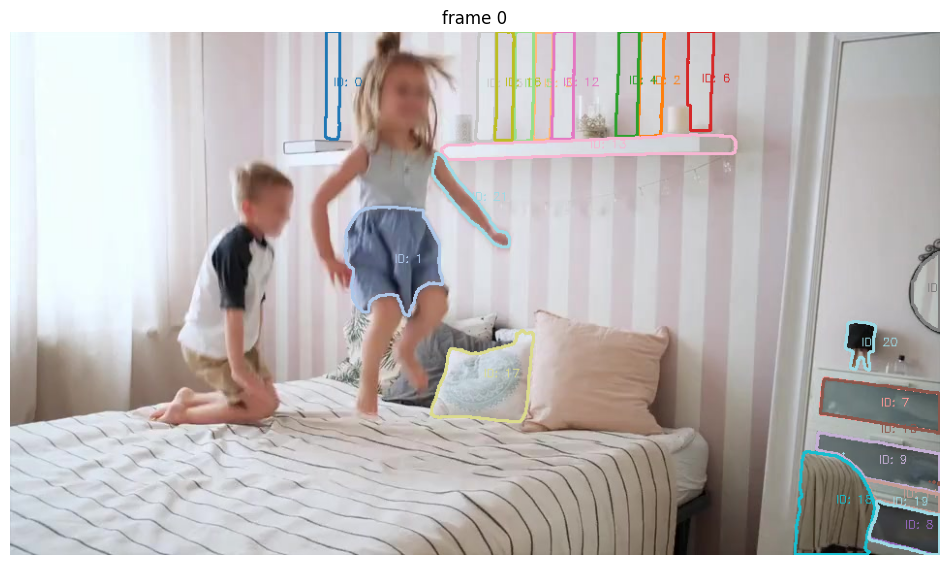

frame 2


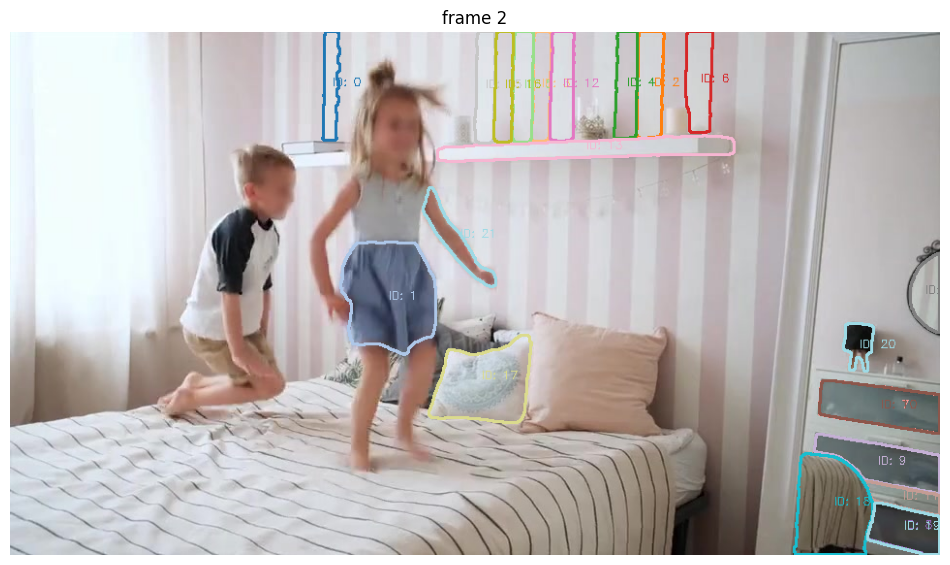

frame 4


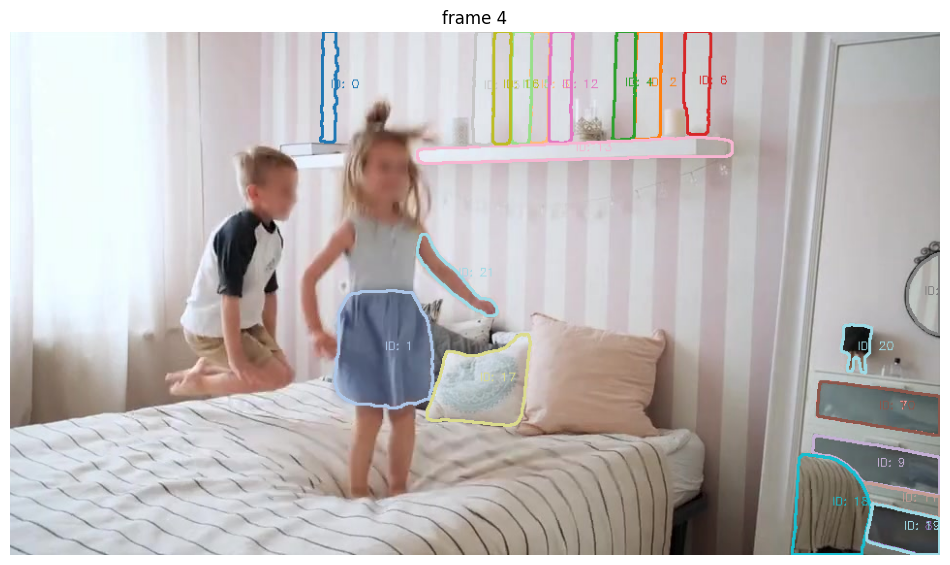

frame 6


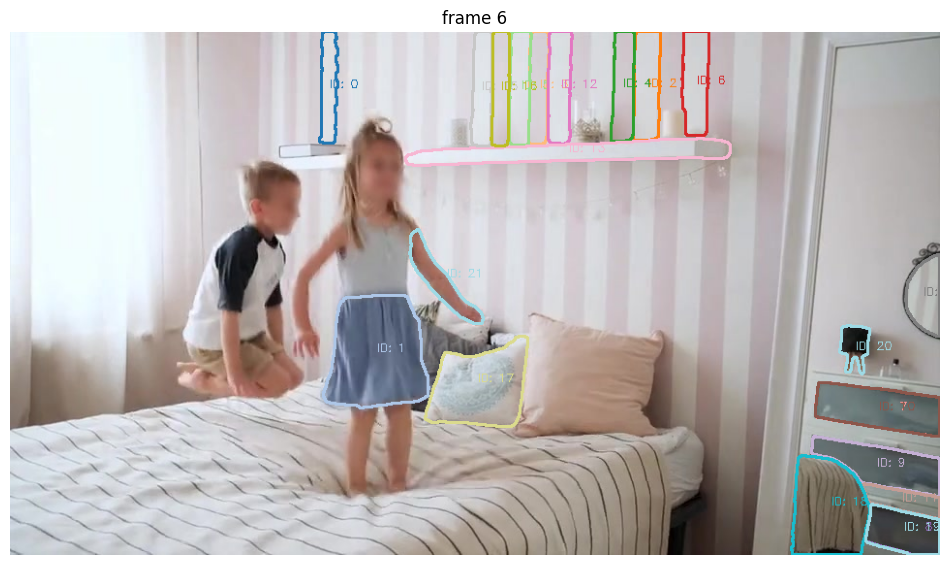

frame 8


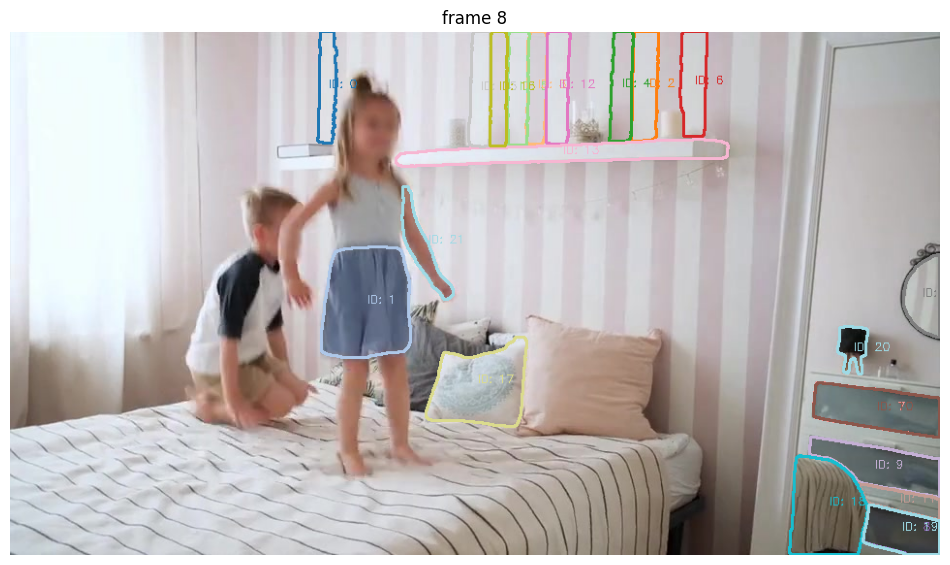

frame 10
Generating masks...
Masks generated.
Number of new masks: 4
last id 26


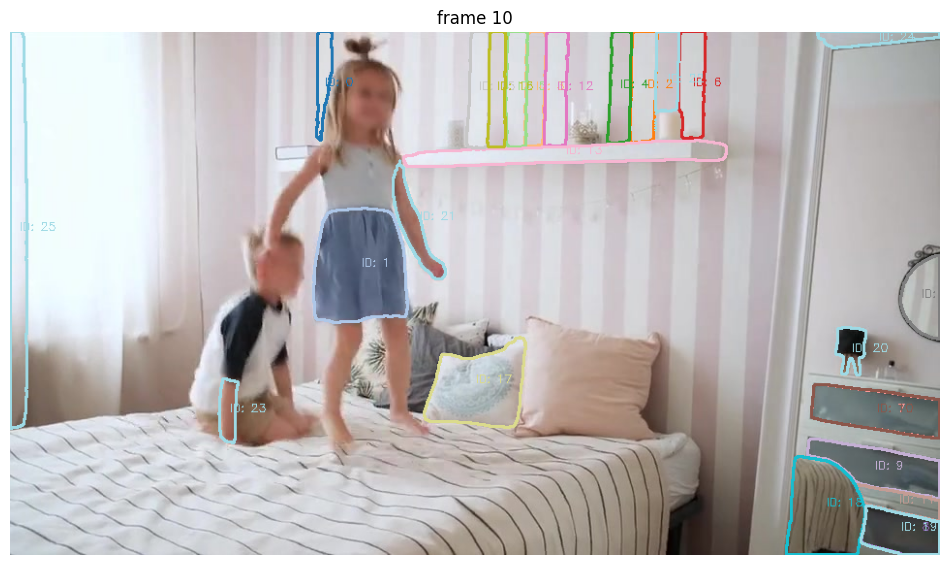

frame 12


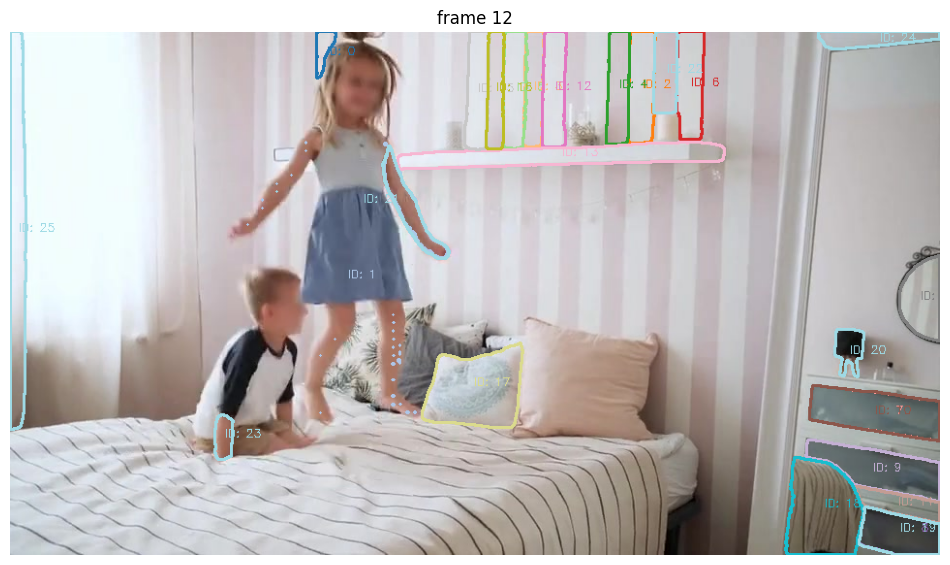

frame 14


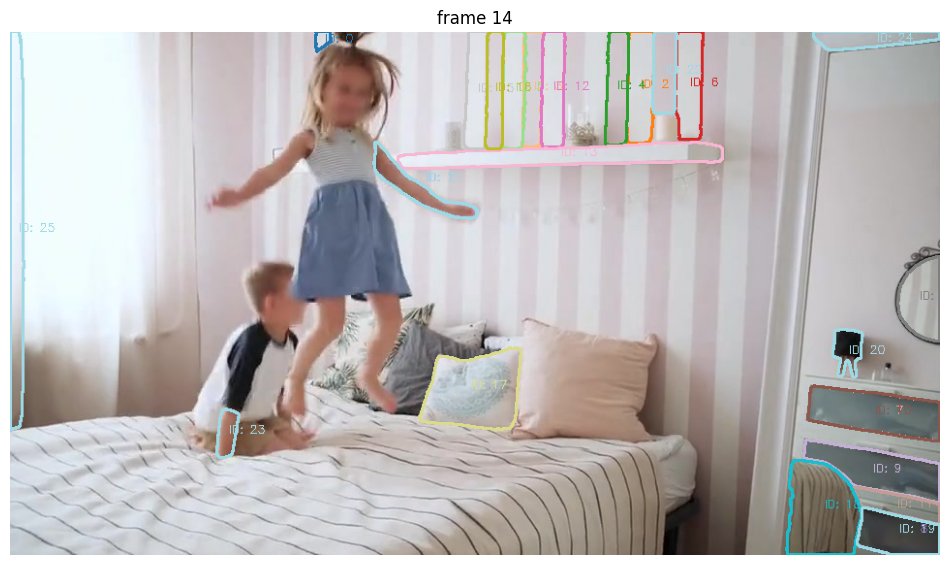

frame 16


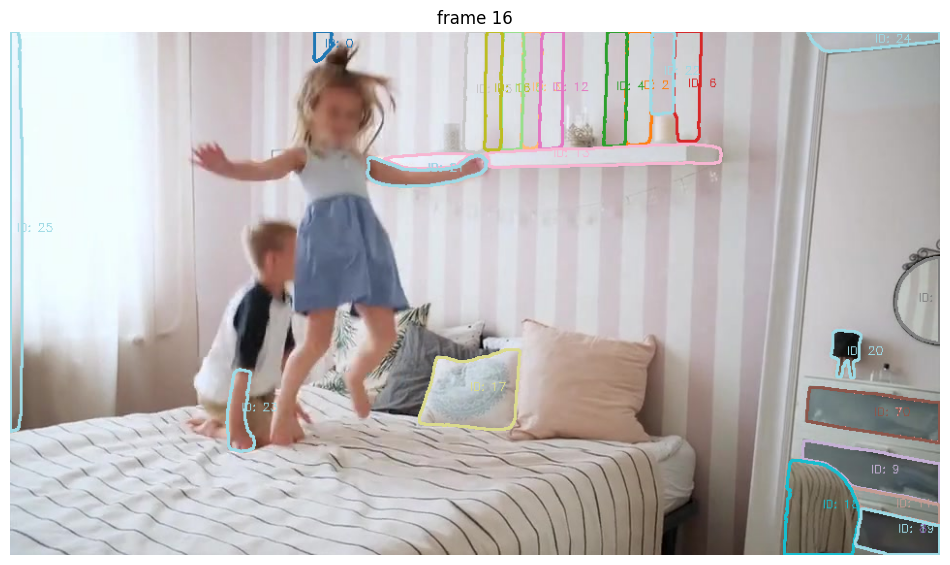

frame 18


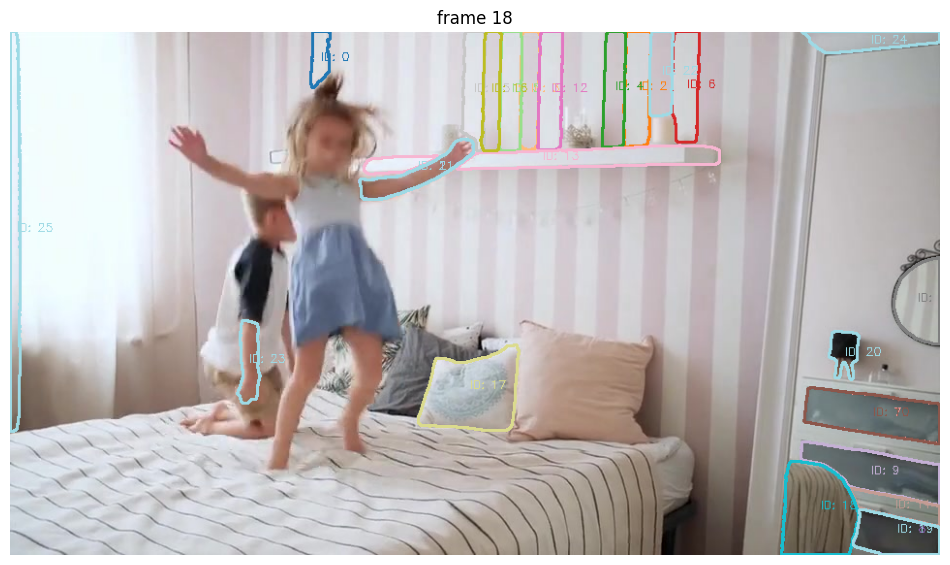

frame 20
Generating masks...
Masks generated.
Number of new masks: 2
last id 28


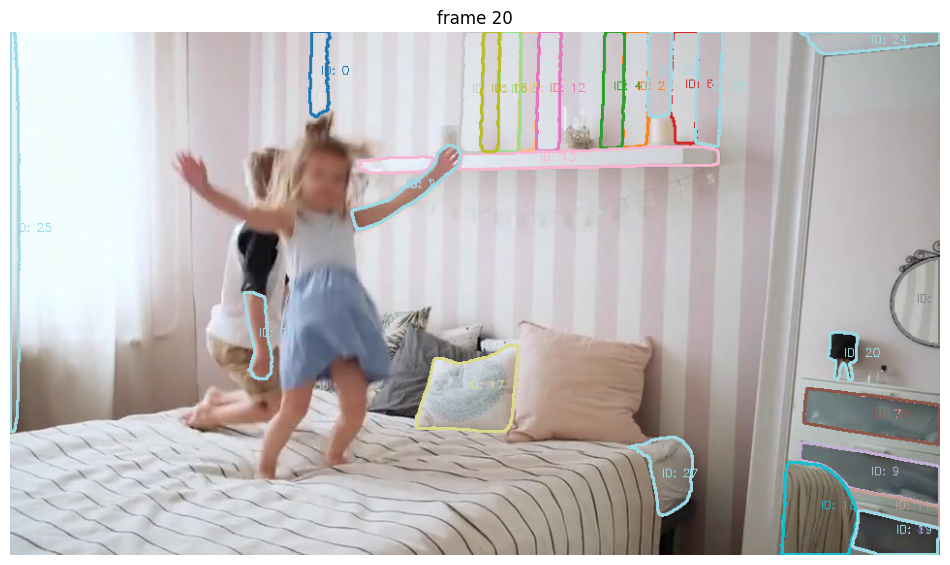

frame 22


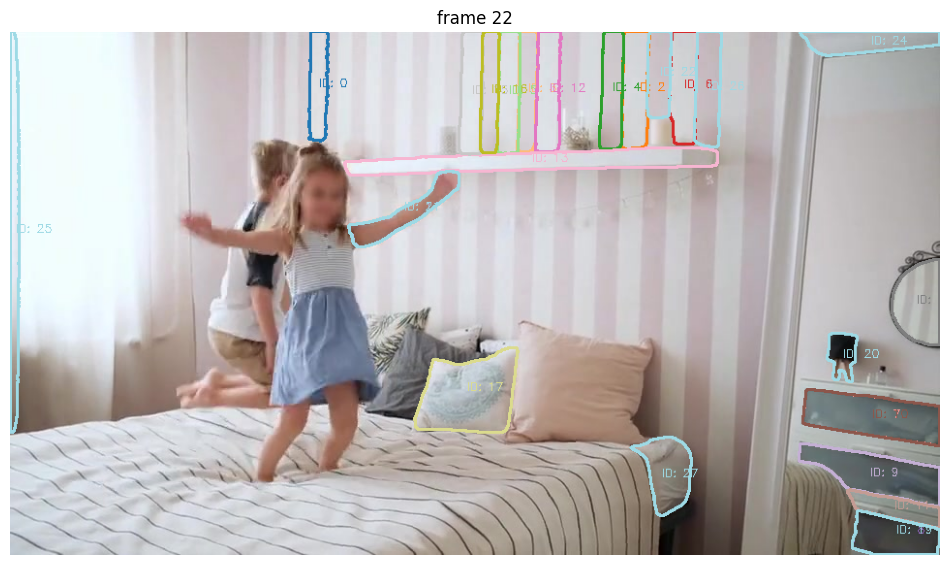

frame 24


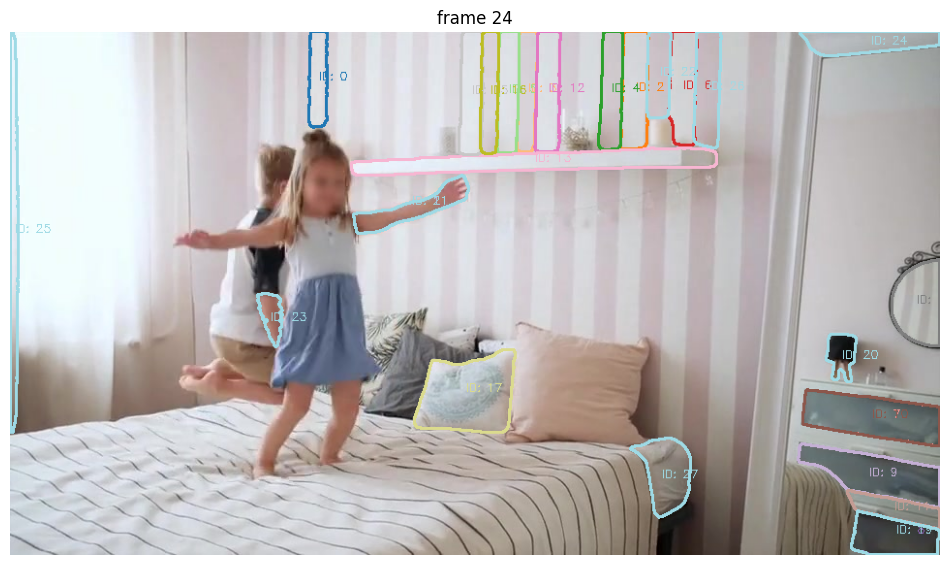

frame 26


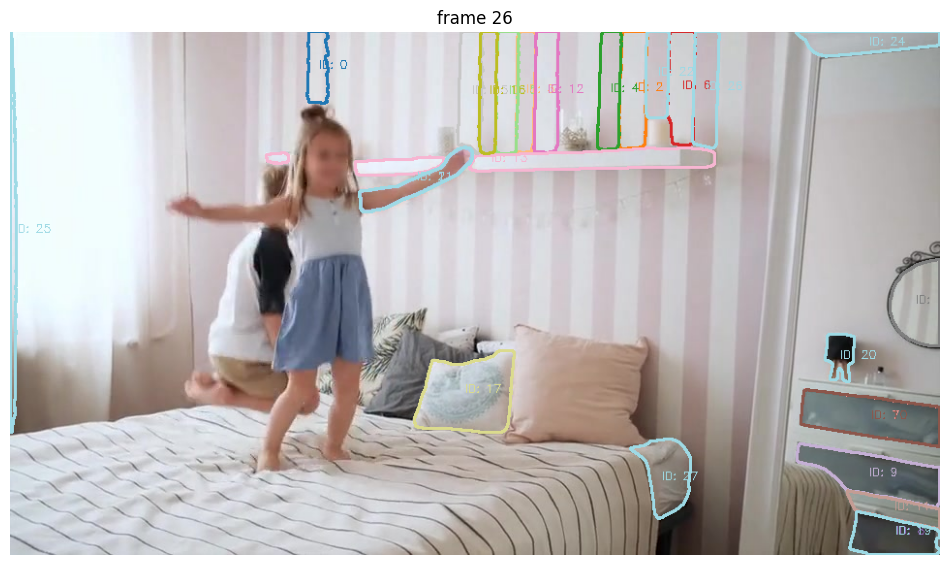

frame 28


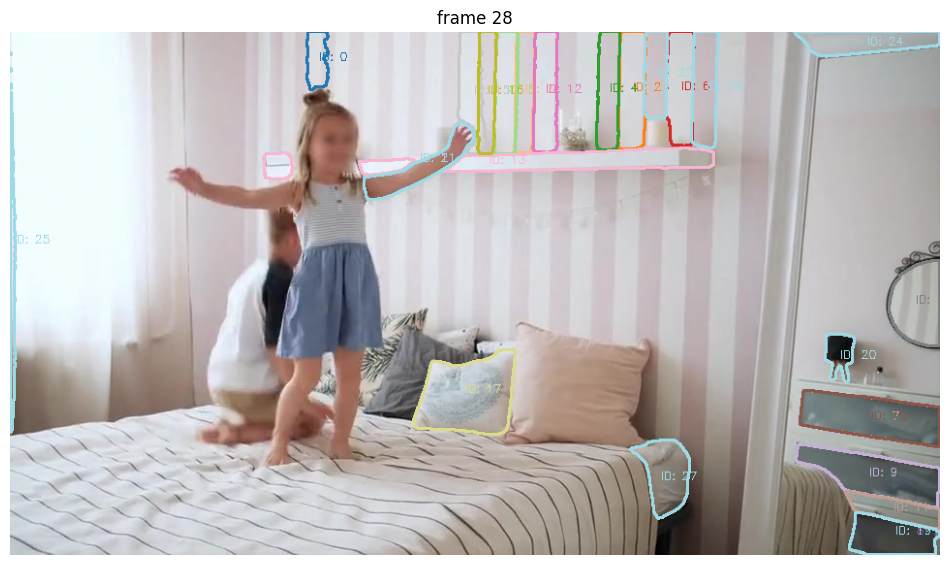

In [26]:
vis_gap = 2
remasks = 10
existing_ids = []
existing_masks = []
last_id = 0
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

cmap = plt.get_cmap("tab20")


for frame_idx in range(30):
    frame_path = os.path.join(video_dir, frames[frame_idx])
    if not os.path.exists(frame_path):
        break

    frame = Image.open(frame_path)
    frame = np.array(frame.convert("RGB"))
    frame_annotated = frame.copy()
    width, height = frame.shape[:2][::-1]


    if (frame_idx % vis_gap == 0 or frame_idx % remasks == 0) and len(existing_masks)!=0:
        os.makedirs(os.path.join(output_dir, f"frame_{frame_idx}"), exist_ok=True)

        print(f"frame {frame_idx}")
        out_obj_ids, out_mask_logits = predictor.track(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


        existing_ids = []
        existing_masks = []
        for out_mask_logit, out_obj_id in zip(out_mask_logits, out_obj_ids):
            mask = (out_mask_logit > 0.0).cpu().numpy()
            existing_ids.append(out_obj_id)
            existing_masks.append(mask)
            kernel = np.ones((31, 31), np.uint8)  # Create a kernel for dilation
            


    if frame_idx % remasks == 0:
        predictor.reset_state()
        masks = extract_masks(frame, existing_masks)
        last_id = add_masks(predictor, frame, masks, existing_ids, existing_masks, last_id)
        print("last id", last_id)

    if (frame_idx % vis_gap == 0 or frame_idx % remasks == 0):
        for mask, id in zip(existing_masks, existing_ids):
            mask = mask.reshape(frame.shape[0], frame.shape[1])
            cv2.imwrite(os.path.join(output_dir, f"frame_{frame_idx}", f"mask_{id}.png"), mask * 255)

            mask = mask.astype(np.uint8) # cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)  # Inflate the mask by 15 pixels
            # masked_image = cv2.bitwise_and(frame, frame, mask=mask)
            x, y, w, h = cv2.boundingRect(mask)
            # cropped_image = masked_image[y:y+h, x:x+w]

            contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            color = np.array([*cmap(id)[:3]]) * 255
            cv2.drawContours(frame_annotated, contours[0], -1, color, 2)
            object_text = f"ID: {id}"
            cv2.putText(frame_annotated, object_text, (round(x+w/2), round(y+h/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color[:3], 1)


        plt.figure(figsize=(12, 8))
        plt.title(f"frame {frame_idx}")
        plt.imshow(frame_annotated)
        plt.axis('off')
        plt.show()


